Requirments
- Implement vanilla GAN
- Implement cGAN
- Implement an alternative Loss function
- Send in the github link for the code of the Project.
- Upload the code to GitHub

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

2025-04-27 12:29:30.877606: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 12:29:30.893950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745749770.913457 1539816 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745749770.919386 1539816 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745749770.934846 1539816 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 2.1 Vanilla GAN
Run the code with the original loss described by Goodfellow and observe the results.

- Discriminator class defines a CNN that takes an image and outputs probability between 0 and 1 (0 for fake and 1 for real)
    - CNN has a series of convolutional layers that reduces spatial dimensions while increasing number of feature maps
    - 64x64 → 32x32 → 16x16 → 8x8 → 4x4 → 1x1
    - Leaky ReLU is the activation function used to introduce non-linearity
- Generator class defines a transposed CNN that takes a noise vector and generates an image
    - Input is a noise vector 
    - Contains a series of transposed convolutional layers that performs upsampling while reducing the number of feature maps
    - Each transposed convolutional layer is followed by ReLU
    - Final layer outputs an image that is passed through a Tanh activation function to produce pixel values in [-1, 1]
    - 1x1 → 4x4 → 8x8 → 16x16 → 32x32 → 64x64
- Weights are initialized using mean of 0.0 and standard deviation of 0.02 for stable training
- Binary Cross Entropy (BCE) loss is used to compare the discriminator's prediction with real or fake data
- Training process for discriminator
    - Pass real images through discriminator to get `disc_real`
    - Compute loss by comparing `disc_real` to tensor of ones from real label using BCE loss
    - Then, generate fake images using generator
    - Pass fake images through discriminator to get `disc_fake`
    - Compute loss by comparing `disc_fake` to tensor of zeros from fake label
    - Compute the total discriminator loss by taking average of both real and fake losses
- Training process for generator
    - Pass fake images through the discriminator again to get output
    - Compute loss by comparing output to a tensor of ones
- Discriminator maximizes log(D(x)) + log(1 - D(G(z))), where D(x) is the probability that a real image is real, and D(G(z)) is the probability that a fake image is real
- Generator maximizes log(D(G(z))), equivalent to minimizing log(1 - D(G(z)))

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(

            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1), # 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, kernel_size=4, stride=2, padding=1), # 16 x 16
            self._block(features_d*2, features_d * 4, kernel_size=4, stride=2, padding=1), # 8 x 8
            self._block(features_d*4, features_d * 8 , kernel_size=4, stride=2, padding=1), # 4 x 4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1 x 1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False # use batch norm hence bias is false
            ),

            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x): 
        return self.discriminator(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # inputs: N x z_dim x 1 x 1
            self._block(z_dim, features_g * 16, kernel_size=4, stride=1, padding=0), # N x f_g*16 4 x 4
            self._block(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1), # 8 x 8 
            self._block(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1), # 16 x 16
            self._block(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1), # 32 x 32  
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1), # 64 x 64 
            nn.Tanh() # output will be [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False # use batch norm hence bias is false
            ),

            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )   
    
    def forward(self, x):
        return self.generator(x)
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W)).to(device)
    z = torch.randn((N, z_dim, 1, 1)).to(device)

    disc = Discriminator(in_channels, 8).to(device)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)

    gen = Generator(z_dim, in_channels, 8).to(device)
    initialize_weights(gen)
    assert gen(z).shape == (N, in_channels, H, W)    

    print("Success! Discriminator and Generator are working as expected.")

test()

LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64 
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range (CHANNELS_IMG)], [0.5 for _ in range (CHANNELS_IMG)]) # general and can be used for img with 3 channels
])

dataset = datasets.MNIST(root='../data', train=True, transform=transforms, download=True)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device) # for generating images
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()


for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
         
        # train discriminator max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # train generator min log(1 - D(G(z))) <=> max log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
            step += 1


Success! Discriminator and Generator are working as expected.
Epoch [0/10] Batch 0/469                 Loss D: 0.6900, loss G: 0.7841
Epoch [0/10] Batch 100/469                 Loss D: 0.0156, loss G: 4.0957
Epoch [0/10] Batch 200/469                 Loss D: 0.4564, loss G: 1.8032
Epoch [0/10] Batch 300/469                 Loss D: 0.3854, loss G: 1.6717
Epoch [0/10] Batch 400/469                 Loss D: 0.5463, loss G: 1.1330
Epoch [1/10] Batch 0/469                 Loss D: 0.6248, loss G: 1.7661
Epoch [1/10] Batch 100/469                 Loss D: 0.5677, loss G: 0.9586
Epoch [1/10] Batch 200/469                 Loss D: 0.8020, loss G: 1.2257
Epoch [1/10] Batch 300/469                 Loss D: 0.5469, loss G: 1.0591
Epoch [1/10] Batch 400/469                 Loss D: 0.5875, loss G: 1.7441
Epoch [2/10] Batch 0/469                 Loss D: 0.5441, loss G: 1.1372
Epoch [2/10] Batch 100/469                 Loss D: 0.5271, loss G: 0.3844
Epoch [2/10] Batch 200/469                 Loss D: 0.508

## 2.2 GAN using Logistic Loss
Run the code for 20k iterations and then for 100k iterations and observe the results in both cases. How/why is the output di!erent for both cases? Try to find a suitable reason for both.

- Key changes involve replacing the BCE Loss with a loss based on the log-probability of the discriminator's outputs, without using the Sigmoid activation in the discriminator's output
- BCE loss may result is slower generator improvement especially in early stages of training and generated images may be less diverse 
- Logistic loss typically leads to faster generator learning and better image quality due to stronger gradients
- Logistic loss reduces likelihood of mode collapse as well

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1), # 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, kernel_size=4, stride=2, padding=1), # 16 x 16
            self._block(features_d*2, features_d * 4, kernel_size=4, stride=2, padding=1), # 8 x 8
            self._block(features_d*4, features_d * 8 , kernel_size=4, stride=2, padding=1), # 4 x 4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1 x 1
            # Removed Sigmoid to output raw logits for logistic loss
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x): 
        return self.discriminator(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # inputs: N x z_dim x 1 x 1
            self._block(z_dim, features_g * 16, kernel_size=4, stride=1, padding=0), # N x f_g*16 4 x 4
            self._block(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1), # 8 x 8 
            self._block(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1), # 16 x 16
            self._block(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1), # 32 x 32  
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1), # 64 x 64 
            nn.Tanh() # output will be [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )   
    
    def forward(self, x):
        return self.generator(x)
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W)).to(device)
    z = torch.randn((N, z_dim, 1, 1)).to(device)

    disc = Discriminator(in_channels, 8).to(device)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)

    gen = Generator(z_dim, in_channels, 8).to(device)
    initialize_weights(gen)
    assert gen(z).shape == (N, in_channels, H, W)    

    print("Success! Discriminator and Generator are working as expected.")

test()

LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64 
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
])

dataset = datasets.MNIST(root="../data", train=True, transform=transforms, download=True)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device) # for generating images
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
         
        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = torch.mean(F.softplus(-disc_real)) # -log(sigmoid(D(x)))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = torch.mean(F.softplus(disc_fake)) # -log(1 - sigmoid(D(G(z))))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # Train Generator: max log(D(G(z))) <-> min -log(sigmoid(D(G(z))))
        output = disc(fake).reshape(-1)
        loss_gen = torch.mean(F.softplus(-output)) # -log(sigmoid(D(G(z))))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
            step += 1

Success! Discriminator and Generator are working as expected.
Epoch [0/10] Batch 0/469                 Loss D: 0.6974, loss G: 0.7677
Epoch [0/10] Batch 100/469                 Loss D: 0.0146, loss G: 4.1419
Epoch [0/10] Batch 200/469                 Loss D: 0.7179, loss G: 0.8321
Epoch [0/10] Batch 300/469                 Loss D: 0.5637, loss G: 1.2383
Epoch [0/10] Batch 400/469                 Loss D: 0.5249, loss G: 0.9678
Epoch [1/10] Batch 0/469                 Loss D: 0.5397, loss G: 1.4864
Epoch [1/10] Batch 100/469                 Loss D: 0.6099, loss G: 0.6589
Epoch [1/10] Batch 200/469                 Loss D: 0.6744, loss G: 0.8505
Epoch [1/10] Batch 300/469                 Loss D: 0.6314, loss G: 0.9794
Epoch [1/10] Batch 400/469                 Loss D: 0.5355, loss G: 0.9166
Epoch [2/10] Batch 0/469                 Loss D: 0.5786, loss G: 0.9653
Epoch [2/10] Batch 100/469                 Loss D: 0.5862, loss G: 0.7154
Epoch [2/10] Batch 200/469                 Loss D: 0.466

In [ ]:
# 20k and 100k log loss
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import os
from itertools import cycle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, kernel_size=4, stride=2, padding=1),
            self._block(features_d*2, features_d * 4, kernel_size=4, stride=2, padding=1),
            self._block(features_d*4, features_d * 8, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x): 
        return self.discriminator(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self._block(z_dim, features_g * 16, kernel_size=4, stride=1, padding=0),
            self._block(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1),
            self._block(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1),
            self._block(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )   
    
    def forward(self, x):
        return self.generator(x)
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64 
CHANNELS_IMG = 1
Z_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
ITERATIONS = [20000, 100000] 

# Data preparation
transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
])

dataset = datasets.MNIST(root="../data", train=True, transform=transforms, download=True)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
data_iter = cycle(loader) 

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

writer_real = SummaryWriter(f"logs/logistic/real")
writer_fake = SummaryWriter(f"logs/logistic/fake")
writer_loss = SummaryWriter(f"logs/logistic/loss")

gen.train()
disc.train()

for max_iterations in ITERATIONS:
    step = 0
    print(f"\nTraining for {max_iterations} iterations with Logistic Loss...")
    os.makedirs(f"results/logistic/{max_iterations}", exist_ok=True)
    
    while step < max_iterations:
        real, _ = next(data_iter)
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
         
        # train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = torch.mean(F.softplus(-disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = torch.mean(F.softplus(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # train Generator: max log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = torch.mean(F.softplus(-output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if step % 1000 == 0 or step == max_iterations - 1:
            print(f"Iteration [{step}/{max_iterations}] Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                writer_loss.add_scalar("Discriminator Loss", loss_disc, global_step=step)
                writer_loss.add_scalar("Generator Loss", loss_gen, global_step=step)
                
                if step == max_iterations - 1:
                    torchvision.utils.save_image(fake, f"results/logistic/{max_iterations}/fake_iter_{step}.png", normalize=True)
                    torchvision.utils.save_image(real[:32], f"results/logistic/{max_iterations}/real.png", normalize=True)
        
        step += 1

writer_real.close()
writer_fake.close()
writer_loss.close()


Training for 20000 iterations with Logistic Loss...
Iteration [0/20000] Loss D: 0.6946, Loss G: 0.7898
Iteration [1000/20000] Loss D: 0.6128, Loss G: 0.9313
Iteration [2000/20000] Loss D: 0.2165, Loss G: 2.4932
Iteration [3000/20000] Loss D: 0.0415, Loss G: 3.5928
Iteration [4000/20000] Loss D: 0.0146, Loss G: 5.0517
Iteration [5000/20000] Loss D: 0.4208, Loss G: 1.7080
Iteration [6000/20000] Loss D: 0.0296, Loss G: 4.0556
Iteration [7000/20000] Loss D: 0.0212, Loss G: 5.1662
Iteration [8000/20000] Loss D: 0.0013, Loss G: 6.4596
Iteration [9000/20000] Loss D: 0.0006, Loss G: 9.1202
Iteration [10000/20000] Loss D: 0.0002, Loss G: 8.1310
Iteration [11000/20000] Loss D: 0.0280, Loss G: 5.4596
Iteration [12000/20000] Loss D: 0.0164, Loss G: 5.3920
Iteration [13000/20000] Loss D: 0.0011, Loss G: 9.5574
Iteration [14000/20000] Loss D: 0.0018, Loss G: 7.4182
Iteration [15000/20000] Loss D: 0.0029, Loss G: 6.2411
Iteration [16000/20000] Loss D: 0.0104, Loss G: 10.1044
Iteration [17000/20000] 

In [ ]:
# 20k and 100k bce loss, mode collapse for 100K
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os
from itertools import cycle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, kernel_size=4, stride=2, padding=1),
            self._block(features_d*2, features_d * 4, kernel_size=4, stride=2, padding=1),
            self._block(features_d*4, features_d * 8, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x): 
        return self.discriminator(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self._block(z_dim, features_g * 16, kernel_size=4, stride=1, padding=0),
            self._block(features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1),
            self._block(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1),
            self._block(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )   
    
    def forward(self, x):
        return self.generator(x)
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64 
CHANNELS_IMG = 1
Z_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
ITERATIONS = [20000, 100000] 

transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
])

dataset = datasets.MNIST(root="../data", train=True, transform=transforms, download=True)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
data_iter = cycle(loader)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

writer_real = SummaryWriter(f"logs/bce/real")
writer_fake = SummaryWriter(f"logs/bce/fake")
writer_loss = SummaryWriter(f"logs/bce/loss")

gen.train()
disc.train()

for max_iterations in ITERATIONS:
    step = 0
    print(f"\nTraining for {max_iterations} iterations with BCELoss...")
    os.makedirs(f"results/bce/{max_iterations}", exist_ok=True)
    
    while step < max_iterations:
        real, _ = next(data_iter)
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
         
        # train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # train Generator: max log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if step % 1000 == 0 or step == max_iterations - 1:
            print(f"Iteration [{step}/{max_iterations}] Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                writer_loss.add_scalar("Discriminator Loss", loss_disc, global_step=step)
                writer_loss.add_scalar("Generator Loss", loss_gen, global_step=step)
                
                # Save images at the end
                if step == max_iterations - 1:
                    torchvision.utils.save_image(fake, f"results/bce/{max_iterations}/fake_iter_{step}.png", normalize=True)
                    torchvision.utils.save_image(real[:32], f"results/bce/{max_iterations}/real.png", normalize=True)
        
        step += 1

writer_real.close()
writer_fake.close()
writer_loss.close()


Training for 20000 iterations with BCELoss...
Iteration [0/20000] Loss D: 0.6925, Loss G: 0.7890
Iteration [1000/20000] Loss D: 0.5804, Loss G: 1.3287
Iteration [2000/20000] Loss D: 0.2829, Loss G: 2.5160
Iteration [3000/20000] Loss D: 0.5596, Loss G: 1.2885
Iteration [4000/20000] Loss D: 0.3187, Loss G: 2.6657
Iteration [5000/20000] Loss D: 0.0514, Loss G: 3.6714
Iteration [6000/20000] Loss D: 0.1667, Loss G: 1.3942
Iteration [7000/20000] Loss D: 2.9112, Loss G: 12.2251
Iteration [8000/20000] Loss D: 0.0474, Loss G: 4.3168
Iteration [9000/20000] Loss D: 0.0238, Loss G: 4.4278
Iteration [10000/20000] Loss D: 0.1149, Loss G: 2.9555
Iteration [11000/20000] Loss D: 0.0164, Loss G: 5.0414
Iteration [12000/20000] Loss D: 0.3736, Loss G: 1.1771
Iteration [13000/20000] Loss D: 0.0170, Loss G: 4.7754
Iteration [14000/20000] Loss D: 0.3511, Loss G: 2.2061
Iteration [15000/20000] Loss D: 0.0226, Loss G: 5.3632
Iteration [16000/20000] Loss D: 0.0902, Loss G: 2.6883
Iteration [17000/20000] Loss D

KeyboardInterrupt: 

- Logistic Loss Performance:
  - Maintains stable training over 20,000 and 100,000 iterations
  - Shows consistent improvements in image quality
  - Balanced loss trends indicate effective learning
- BCE Loss Performance:
  - Results in unstable training with oscillations at 20,000 iterations
  - Experiences complete collapse at 100,000 iterations
  - Likely produces inconsistent or unusable images
- Reasons for Differences:
  - Logistic Loss:
    - Non-saturating formulation provides robust gradients
    - Numerical stability prevents extreme loss values
  - BCE Loss:
    - Suffers from vanishing gradients due to saturating loss
    - Disrupts adversarial balance, leading to training failure

## 2.3 CGAN
- CGAN extends the GAN framework by conditioning both generator and discriminator on additional information such as class labels
- Generator takes random noise and a class label to produce a fake image of the specified class
- Discriminator evaluates whether an image is real or fake given its class label
- The key difference lies in the forward pass where the forward method concats the flattened image and one-hot encoded class label
- For the generator, a class label is added to the noise vector to generate a fake image

Epoch [0/50] Batch 0/469 Loss D: 0.6202, Loss G: 0.6752
Epoch [0/50] Batch 100/469 Loss D: 0.4952, Loss G: 0.7915
Epoch [0/50] Batch 200/469 Loss D: 0.1143, Loss G: 2.3504
Epoch [0/50] Batch 300/469 Loss D: 0.1412, Loss G: 1.7423
Epoch [0/50] Batch 400/469 Loss D: 0.4559, Loss G: 0.7145
Epoch [1/50] Batch 0/469 Loss D: 0.2809, Loss G: 1.2921
Epoch [1/50] Batch 100/469 Loss D: 0.2789, Loss G: 1.3641
Epoch [1/50] Batch 200/469 Loss D: 0.3299, Loss G: 1.4012
Epoch [1/50] Batch 300/469 Loss D: 0.1436, Loss G: 2.1587
Epoch [1/50] Batch 400/469 Loss D: 0.2188, Loss G: 1.8695
Epoch [2/50] Batch 0/469 Loss D: 0.5399, Loss G: 1.1462
Epoch [2/50] Batch 100/469 Loss D: 0.2786, Loss G: 1.5063
Epoch [2/50] Batch 200/469 Loss D: 0.3558, Loss G: 1.3743
Epoch [2/50] Batch 300/469 Loss D: 0.2881, Loss G: 1.5401
Epoch [2/50] Batch 400/469 Loss D: 0.6116, Loss G: 0.9685
Epoch [3/50] Batch 0/469 Loss D: 0.3637, Loss G: 1.6112
Epoch [3/50] Batch 100/469 Loss D: 0.1696, Loss G: 1.9642
Epoch [3/50] Batch 200

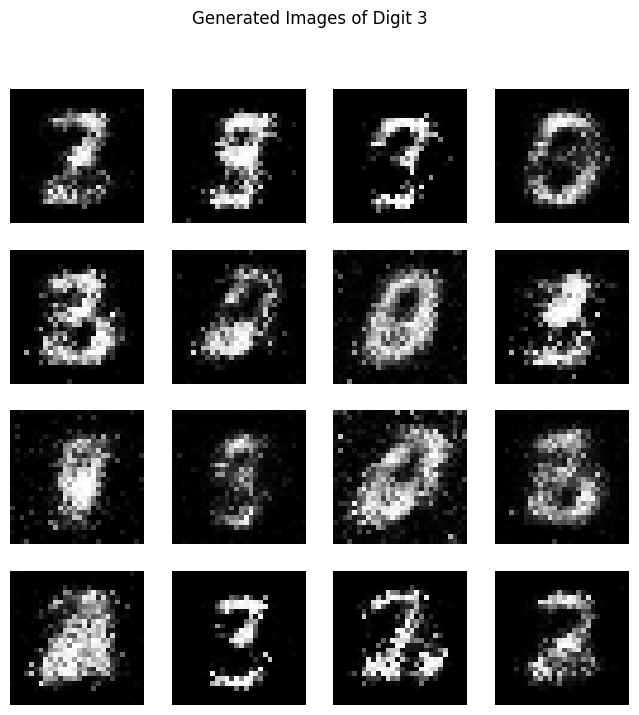

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# discriminator class for CGAN
class Discriminator(nn.Module):
    def __init__(self, img_dim, num_classes):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(img_dim + num_classes, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, c_onehot):
        input = torch.cat((x, c_onehot), dim=1)
        return self.discriminator(input)

# generator class for CGAN
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, num_classes):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, z, c_onehot):
        input = torch.cat((z, c_onehot), dim=1)
        return self.generator(input)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 3e-4
BATCH_SIZE = 128
IMAGE_SIZE = 28 * 28  # 784 for MNIST
CHANNELS_IMG = 1
Z_DIM = 64
NUM_EPOCHS = 50
NUM_CLASSES = 10  # for digits 0-9

# transforms for MNIST dataset
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# load MNIST dataset
dataset = datasets.MNIST(root='../data', train=True, transform=transforms, download=True)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

# initialize models
discriminator = Discriminator(IMAGE_SIZE, NUM_CLASSES).to(device)
generator = Generator(Z_DIM, IMAGE_SIZE, NUM_CLASSES).to(device)

# fixed noise for visualization
fixed_noise = torch.randn((BATCH_SIZE, Z_DIM)).to(device)
fixed_labels = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,)).to(device)
fixed_labels_onehot = nn.functional.one_hot(fixed_labels, num_classes=NUM_CLASSES).float().to(device)

# optimizers
opt_disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
opt_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE)

# loss function
criterion = nn.BCELoss()

# TensorBoard writers
writer_fake = SummaryWriter(f"logs/gan/cgan/fake")
writer_real = SummaryWriter(f"logs/gan/cgan/real")

# training loop
step = 0
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, real_labels) in enumerate(loader):
        real = real.view(-1, 28*28).to(device)
        real_labels = real_labels.to(device)
        batch_size = real.shape[0]

        # prepare one-hot encoded labels for real and fake data
        real_labels_onehot = nn.functional.one_hot(real_labels, num_classes=NUM_CLASSES).float().to(device)
        fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,)).to(device)
        fake_labels_onehot = nn.functional.one_hot(fake_labels, num_classes=NUM_CLASSES).float().to(device)

        # generate noise and fake images
        noise = torch.randn(batch_size, Z_DIM).to(device)
        fake = generator(noise, fake_labels_onehot)

        # train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = discriminator(real, real_labels_onehot).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake.detach(), fake_labels_onehot).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # train Generator: min log(1 - D(G(z))) or max log(D(G(z)))
        output = discriminator(fake, fake_labels_onehot).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # logging and visualization
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                # Generate fake images with fixed noise and labels
                fake = generator(fixed_noise, fixed_labels_onehot).view(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                img_grid_real = torchvision.utils.make_grid(real[:32].view(-1, 1, 28, 28), normalize=True)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                writer_real.add_image("Real", img_grid_real, global_step=step)
            step += 1

# after training, generate and plot images of a specific digit
generator.eval()
with torch.no_grad():
    num_samples = 16
    fixed_noise = torch.randn(num_samples, Z_DIM).to(device)
    fixed_labels = torch.full((num_samples,), 3, device=device)  # digit 3
    fixed_labels_onehot = nn.functional.one_hot(fixed_labels, num_classes=NUM_CLASSES).float().to(device)
    fake_images = generator(fixed_noise, fixed_labels_onehot).view(-1, 1, 28, 28).cpu()

    # plot the generated images
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle("Generated Images of Digit 3")
    plt.show()

## 2.4 CNN MNIST to Create Adversarial Images

Epoch [1/50] completed
Epoch [2/50] completed
Epoch [3/50] completed
Epoch [4/50] completed
Epoch [5/50] completed
Epoch [6/50] completed
Epoch [7/50] completed
Epoch [8/50] completed
Epoch [9/50] completed
Epoch [10/50] completed
Epoch [11/50] completed
Epoch [12/50] completed
Epoch [13/50] completed
Epoch [14/50] completed
Epoch [15/50] completed
Epoch [16/50] completed
Epoch [17/50] completed
Epoch [18/50] completed
Epoch [19/50] completed
Epoch [20/50] completed
Epoch [21/50] completed
Epoch [22/50] completed
Epoch [23/50] completed
Epoch [24/50] completed
Epoch [25/50] completed
Epoch [26/50] completed
Epoch [27/50] completed
Epoch [28/50] completed
Epoch [29/50] completed
Epoch [30/50] completed
Epoch [31/50] completed
Epoch [32/50] completed
Epoch [33/50] completed
Epoch [34/50] completed
Epoch [35/50] completed
Epoch [36/50] completed
Epoch [37/50] completed
Epoch [38/50] completed
Epoch [39/50] completed
Epoch [40/50] completed
Epoch [41/50] completed
Epoch [42/50] completed
E

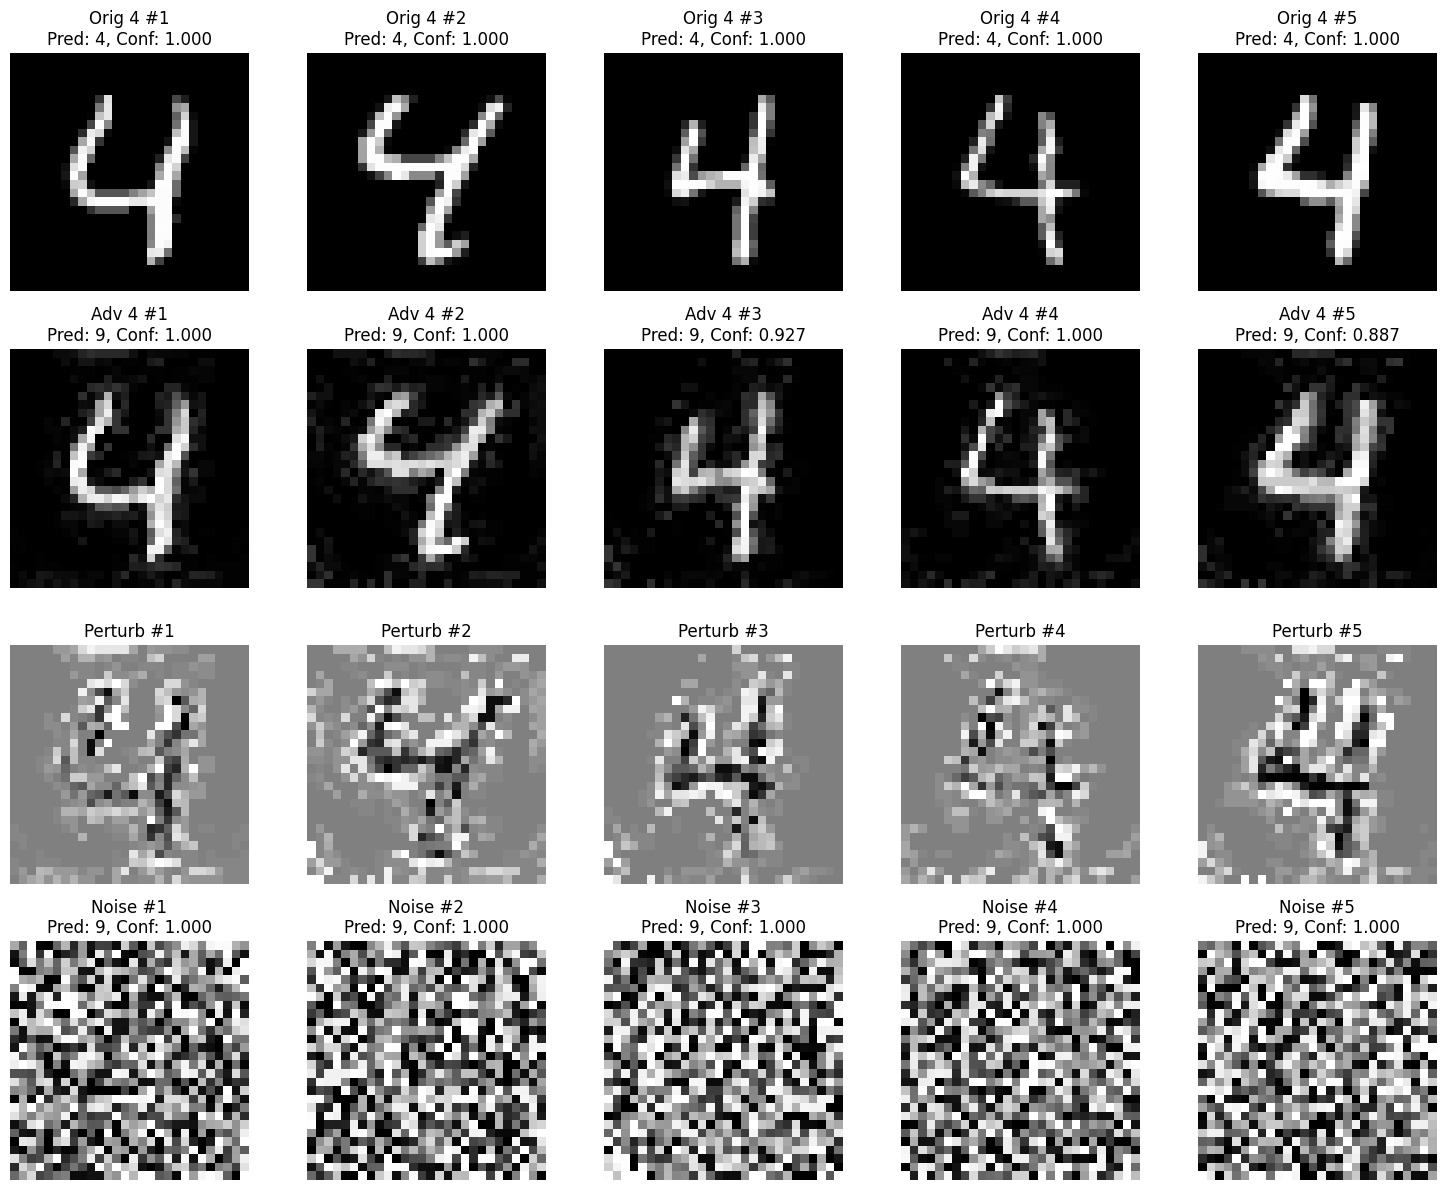

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# dataset setup
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 50 
learning_rate = 0.003
epsilon = 0.4  
alpha = 0.02   # step size
num_iter = 20  # iterations for PGD
num_4s = 5    # number of 4s to attack
num_noise_images = 5  # number of noise images
num_steps = 200  # steps for noise optimization

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize and train model
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}] completed')

# evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')

# PGD targeted attack function
def pgd_targeted(model, image, target_label, epsilon=0.3, alpha=0.02, num_iter=20):
    adv_image = image.clone().detach().to(device)
    original_image = image.clone().detach().to(device)
    for _ in range(num_iter):
        adv_image.requires_grad = True
        output = model(adv_image)
        loss = criterion(output, target_label)
        model.zero_grad()
        loss.backward()
        perturbation = alpha * adv_image.grad.sign()
        adv_image = adv_image - perturbation  # minimize loss 
        adv_image = torch.clamp(adv_image, original_image - epsilon, original_image + epsilon)
        adv_image = torch.clamp(adv_image, -1, 1)  # respect normalization
        adv_image = adv_image.detach()
    return adv_image

# select multiple 4s from test set
original_images = []
original_preds = []
original_confs = []
adv_images = []
adv_preds = []
adv_confs = []
perturbations = []
target_label = torch.tensor([9]).to(device)
count = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    indices = (labels == 4).nonzero(as_tuple=True)[0]
    for idx in indices:
        if count >= num_4s:
            break
        original_image = images[idx:idx+1]
        # original
        with torch.no_grad():
            output = model(original_image)
            pred = torch.argmax(output, dim=1).item()
            conf = F.softmax(output, dim=1)[0, pred].item()
        original_images.append(original_image)
        original_preds.append(pred)
        original_confs.append(conf)
        # adversarial image
        adv_image = pgd_targeted(model, original_image, target_label, epsilon, alpha, num_iter)
        with torch.no_grad():
            adv_output = model(adv_image)
            adv_pred = torch.argmax(adv_output, dim=1).item()
            adv_conf = F.softmax(adv_output, dim=1)[0, adv_pred].item()
        adv_images.append(adv_image)
        adv_preds.append(adv_pred)
        adv_confs.append(adv_conf)
        # perturbation
        perturbation = adv_image - original_image
        perturbations.append(perturbation)
        print(f'Original image {count+1} predicted as: {pred} with confidence {conf:.4f}')
        print(f'Adversarial image {count+1} predicted as: {adv_pred} with confidence {adv_conf:.4f}')
        count += 1
    if count >= num_4s:
        break

# generate multiple adversarial noise images
noise_images = []
noise_preds = []
noise_confs = []
for i in range(num_noise_images):
    noise_image = torch.randn(1, 1, 28, 28).to(device)
    noise_image = torch.clamp(noise_image, -1, 1)
    noise_image.requires_grad = True
    optimizer_noise = torch.optim.Adam([noise_image], lr=0.01)
    for step in range(num_steps):
        output = model(noise_image)
        loss = criterion(output, target_label)
        model.zero_grad()
        optimizer_noise.zero_grad()
        loss.backward()
        optimizer_noise.step()
        noise_image.data = torch.clamp(noise_image.data, -1, 1)
    noise_image = noise_image.detach()
    with torch.no_grad():
        noise_output = model(noise_image)
        noise_pred = torch.argmax(noise_output, dim=1).item()
        noise_conf = F.softmax(noise_output, dim=1)[0, noise_pred].item()
    noise_images.append(noise_image)
    noise_preds.append(noise_pred)
    noise_confs.append(noise_conf)
    print(f'Adversarial noise image {i+1} predicted as: {noise_pred} with confidence {noise_conf:.4f}')


def denormalize(image):
    return (image + 1) / 2

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
# original 4s
for i in range(num_4s):
    axes[0, i].imshow(denormalize(original_images[i].cpu()).squeeze(), cmap='gray')
    axes[0, i].set_title(f'Orig 4 #{i+1}\nPred: {original_preds[i]}, Conf: {original_confs[i]:.3f}')
# adversarial 4s
for i in range(num_4s):
    axes[1, i].imshow(denormalize(adv_images[i].cpu()).squeeze(), cmap='gray')
    axes[1, i].set_title(f'Adv 4 #{i+1}\nPred: {adv_preds[i]}, Conf: {adv_confs[i]:.3f}')
# perturbations
for i in range(num_4s):
    axes[2, i].imshow(denormalize(perturbations[i].cpu()).squeeze(), cmap='gray')
    axes[2, i].set_title(f'Perturb #{i+1}')
# noise images
for i in range(num_noise_images):
    axes[3, i].imshow(denormalize(noise_images[i].cpu()).squeeze(), cmap='gray')
    axes[3, i].set_title(f'Noise #{i+1}\nPred: {noise_preds[i]}, Conf: {noise_confs[i]:.3f}')
# empty subplots
for i in range(num_noise_images, 5):
    axes[3, i].axis('off')
for ax in axes.flat:
    ax.axis('off')
plt.tight_layout()
plt.savefig('adversarial_images_with_perturbations.png')
plt.show()

## 2.5 Stable Diffusion
What is the main di!erence between GAN and stable diffusion?
- GANs consists of 2 neural networks — generator and discriminator
- Stable Diffusion consists of a latent diffusion model that combines a VAE and diffusion model
- GANs are trained via adversarial loss 
    - Minimize generator loss while maximizing discriminator accuracy
- Stable Diffusion is trained using a process where model learns to reverse a noise-adding process
    - Minimize the difference between the predicted noise and actual noise added to the data at each step
- GANs generate images from random noise vectors or class labels
- Stable Diffusion is highly flexible and typically conditioned on text prompts using pre-trained LM to guide image generation
- GANs directly generate images in pixel space, can be computationally expensive 
- Stable Diffusion operates in compressed latent space, more memory and computationally efficient


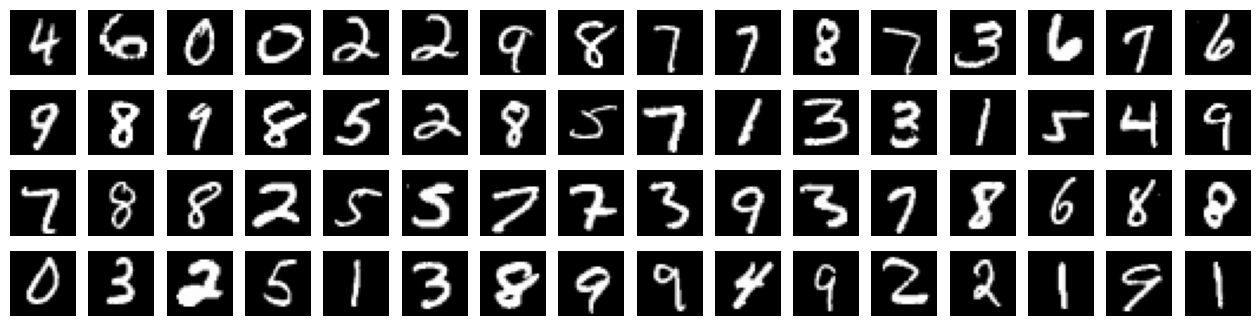

In [7]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# load the training dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# get a batch of unique images
unique_images, unique_labels = next(iter(train_loader))
unique_images = unique_images.numpy()

fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True) 

for i in range(4):
    for j in range(16): 
        index = i * 16 + j 
        axes[i, j].imshow(unique_images[index].squeeze(), cmap='gray') 
        axes[i, j].axis('off')  

plt.show() 

In [8]:
!pip install tqdm einops ipywidgets jupyter widgetsnbextension pandas-profiling
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


### Forward Diffusion
- Adds Gaussian noise to an image progressively until only random noise remains
- Used during training but not for other tasks, except image-to-image conversion

In [9]:
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - t0: Initial time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for diffusion simulation
    for i in range(nsteps):

        # Get the noise strength at the current time
        noise_strength = noise_strength_fn(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler-Maruyama method
        x[i + 1] = x[i] + random_normal * noise_strength

    # Return the trajectory and corresponding time points
    return x, t

# Example noise strength function: always equal to 1
def noise_strength_constant(t):
    """
    Example noise strength function that returns a constant value (1).

    Parameters:
    - t: Time parameter (unused in this example)

    Returns:
    - Constant noise strength (1)
    """
    return 1

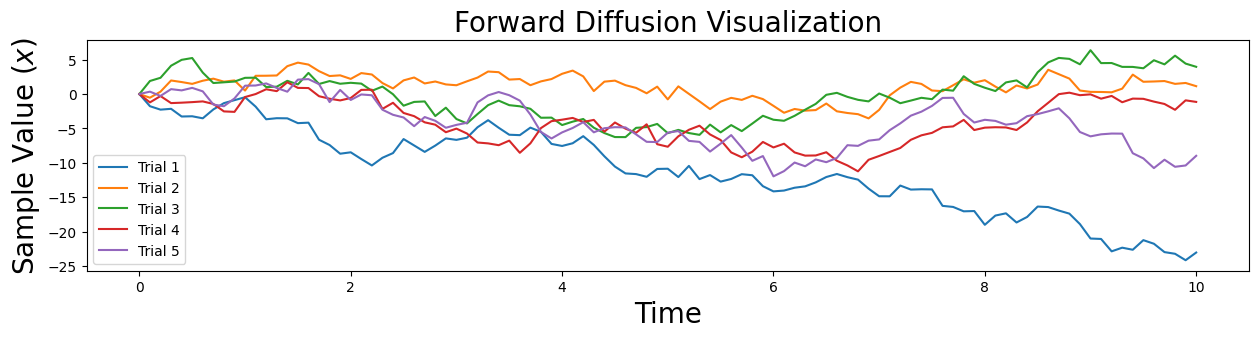

In [10]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_constant

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)
plt.title('Forward Diffusion Visualization', fontsize=20)
plt.legend()
plt.show()


### Reverse Diffusion
- Iteratively undoes forward diffusion
- Trained on billions of images using prompts to create unique images


In [11]:
# Reverse diffusion for N steps in 1D.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - score_fn: Score function
    - T: Final time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for reverse diffusion simulation
    for i in range(nsteps):

        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])

        # Calculate the score using the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using the reverse Euler-Maruyama method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    # Return the trajectory and corresponding time points
    return x, t

In [12]:
# Example score function: always equal to 1
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """

    # Calculate the score using the provided formula
    score = - (x - x0) / ((noise_strength**2) * t)

    # Return the calculated score
    return score

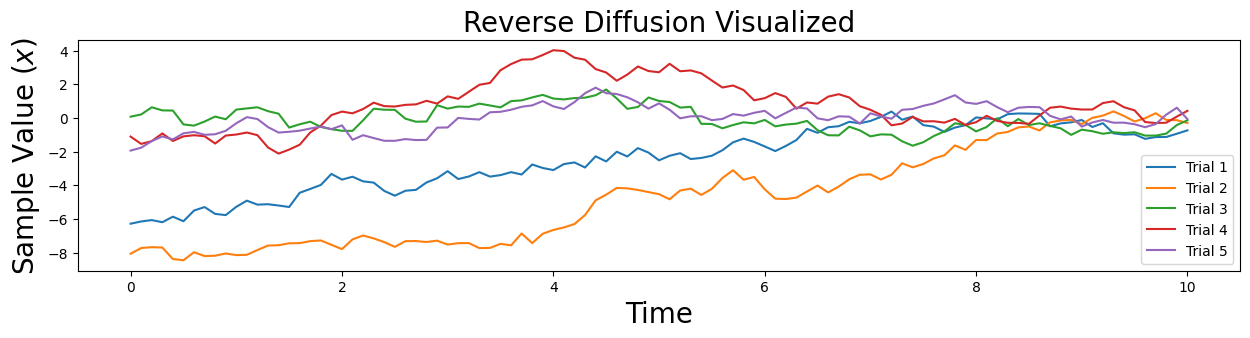

In [13]:
# Number of reverse diffusion steps
nsteps = 100

# Initial time for reverse diffusion
t0 = 0

# Time step size for reverse diffusion
dt = 0.1

# Function defining constant noise strength for reverse diffusion
noise_strength_fn = noise_strength_constant

# Example score function for reverse diffusion
score_fn = score_simple

# Initial sample value for reverse diffusion
x0 = 0

# Final time for reverse diffusion
T = 11

# Number of tries for visualization
num_tries = 5

plt.figure(figsize=(15, 3))

for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)
plt.title('Reverse Diffusion Visualized', fontsize=20)
plt.legend()
plt.show()

In [14]:
# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [15]:
# Define a module for a fully connected layer that reshapes outputs to feature maps.
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.

### U-Net

In [16]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        # Additional encoding layers (copied from the original code)
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        # Additional encoding path layers (copied from the original code)
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [17]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [18]:
# Marginal Probability Standard Deviation Function
def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)

    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [19]:
def diffusion_coeff(t, sigma):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)


In [20]:
# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [21]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)

    # Generate normally distributed noise
    z = torch.randn_like(x)

    # Perturb the input data with the generated noise
    perturbed_x = x + z * std[:, None, None, None]

    # Get the score from the model using the perturbed data and time
    score = model(perturbed_x, random_t)

    # Calculate the loss based on the score and noise
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))

    return loss

In [22]:
# Number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                            marginal_prob_std,
                            diffusion_coeff,
                            batch_size=64,
                            x_shape=(1, 28, 28),
                            num_steps=num_steps,
                            device='cuda',
                            eps=1e-3, y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x

In [23]:
# Define the score-based model and move it to the specified device
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Number of training epochs
n_epochs = 50
# Size of a mini-batch
batch_size = 2048
# Learning rate
lr = 5e-4

# Load the MNIST dataset and create a data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the Adam optimizer for training the model
optimizer = Adam(score_model.parameters(), lr=lr)

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_1535362/994099706.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_1535362/994099706.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_1535362/1259072587.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


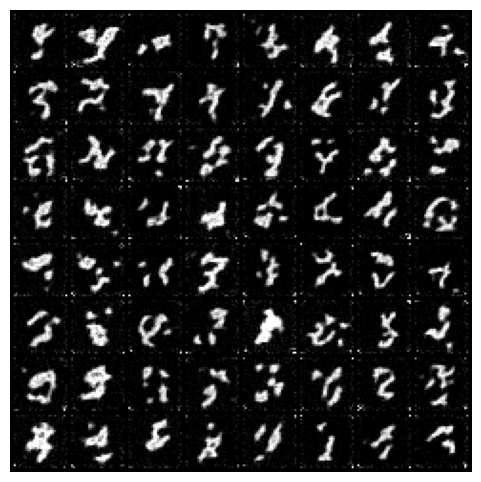

In [24]:
# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [25]:
# Initialize the alternate U-Net model for training.
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Set the number of training epochs, mini-batch size, and learning rate.
n_epochs = 75
batch_size = 1024
lr = 1e-3

# Load the MNIST dataset for training.
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the Adam optimizer with the specified learning rate.
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Training loop over epochs.
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate over mini-batches in the training data loader.
    for x, y in data_loader:
        x = x.to(device)
        # Compute the loss for the current mini-batch.
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        # Zero the gradients, backpropagate, and update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate the total loss and the number of processed items.
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust the learning rate using the scheduler.
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print the average loss and learning rate for the current epoch.
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_res.pth')

  0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_1535362/994099706.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 707.458287 lr 9.8e-04
1 Average Loss: 210.540944 lr 9.6e-04
2 Average Loss: 142.265983 lr 9.4e-04
3 Average Loss: 109.591036 lr 9.2e-04
4 Average Loss: 90.488433 lr 9.0e-04
5 Average Loss: 77.686574 lr 8.9e-04
6 Average Loss: 68.996726 lr 8.7e-04
7 Average Loss: 62.488720 lr 8.5e-04
8 Average Loss: 57.441741 lr 8.3e-04
9 Average Loss: 53.803936 lr 8.2e-04
10 Average Loss: 50.435718 lr 8.0e-04
11 Average Loss: 47.996782 lr 7.8e-04
12 Average Loss: 45.394723 lr 7.7e-04
13 Average Loss: 44.046318 lr 7.5e-04
14 Average Loss: 42.454590 lr 7.4e-04
15 Average Loss: 40.914867 lr 7.2e-04
16 Average Loss: 40.046120 lr 7.1e-04
17 Average Loss: 39.272667 lr 7.0e-04
18 Average Loss: 37.699990 lr 6.8e-04
19 Average Loss: 37.131364 lr 6.7e-04
20 Average Loss: 36.188167 lr 6.5e-04
21 Average Loss: 35.435701 lr 6.4e-04
22 Average Loss: 34.638359 lr 6.3e-04
23 Average Loss: 34.029062 lr 6.2e-04
24 Average Loss: 34.005058 lr 6.0e-04
25 Average Loss: 33.178717 lr 5.9e-04
26 Average Loss: 3

/tmp/ipykernel_1535362/994099706.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_1535362/1259072587.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


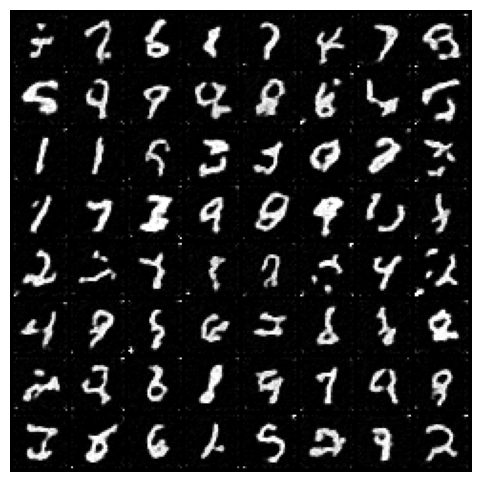

In [26]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt_res.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [27]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim


        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)

        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                    If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

In [28]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

In [29]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()

        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

In [30]:
class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                  text_dim=256, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor.
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


In [31]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

In [32]:
# Specify whether to continue training or initialize a new model

continue_training = False # Either True or False

if not continue_training:

    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

# Set training hyperparameters
n_epochs =   100   #{'type':'integer'}
batch_size =  1024 #{'type':'integer'}
lr = 10e-4         #{'type':'number'}

# Load the MNIST dataset and create a data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the optimizer and learning rate scheduler
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    # Iterate over batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)

        # Compute the loss using the conditional score-based model
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print epoch information including average loss and current learning rate
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/tmp/ipykernel_1535362/994099706.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 760.357316 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 226.826776 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 155.166493 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 121.366468 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 101.393032 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 87.568365 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 76.563485 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 68.871531 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 63.056643 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 58.751112 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 54.517505 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 51.762204 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 49.144323 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 46.567018 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 44.451813 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 42.687930 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 41.413602 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 39.742286 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 38.852050 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 37.388057 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 36.616705 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 37.037200 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 35.362922 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 34.755111 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 34.164608 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 33.443743 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 32.841011 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 32.551808 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 32.335110 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 31.836987 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 31.355011 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 30.970678 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 30.413837 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 30.153875 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 29.877832 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 29.608034 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 28.982232 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 29.068172 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 28.476977 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 27.959622 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 27.968178 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 27.843423 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 27.376802 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 27.276866 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 26.913695 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 26.765934 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 26.511063 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 26.538384 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 26.020901 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 25.831957 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 25.483713 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 25.426470 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 25.352895 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 25.259630 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 25.055065 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 24.957022 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 24.711129 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 24.439741 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 24.464951 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 24.252653 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 24.165240 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 23.748642 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 24.025770 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 23.579646 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 23.668029 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 23.450392 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 23.384452 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 23.409981 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 23.095999 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 22.706104 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 22.736121 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 22.814271 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 22.771877 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 22.833839 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 22.491736 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 22.371877 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 22.472149 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 22.226027 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 22.266025 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 22.233210 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 22.210248 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 22.023958 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 22.071247 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 22.124238 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 21.862189 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 21.761091 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 21.589420 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 21.695759 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 21.342481 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 21.610341 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 21.460200 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 21.704778 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 21.357511 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 21.226084 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 21.374667 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 21.215339 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 21.051237 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 21.122194 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 20.807375 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 20.817413 lr 2.0e-04


/tmp/ipykernel_1535362/994099706.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_1535362/1259072587.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


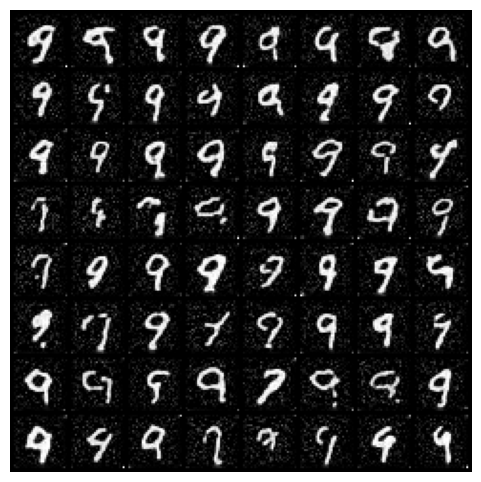

In [33]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_transformer.pth', map_location=device)
score_model.load_state_dict(ckpt)


########### Specify the digit for which to generate samples
###########
digit = 9
###########
###########



# Set the batch size for generating samples
sample_batch_size = 64
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 250
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = Euler_Maruyama_sampler # ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the generated samples
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()